In [1]:
import pandas as pd
import re
import numpy as np
import pickle
import scipy
import os

# Preprocessing

In [2]:
def remove_extra(s):
    return(re.sub(r'\([^\d]*\)|\{.*\}|\'|\"', "", s).strip())

In [3]:
def get_non_duplicated(artist_dataframe):
    artist_counts = artist_dataframe[['movies','artist']].groupby('artist',as_index=False).agg(['count'])
    artist_counts.columns = [''.join(col).strip() for col in artist_counts.columns.values]
    artist_counts2 = artist_counts.reset_index()
    print('Only',artist_counts2['artist'].count(),' unique names')
    
    artist_counts2  = artist_counts2.loc[artist_counts2['moviescount'] >1]
    duplicate_artists = list(artist_counts2['artist'].values)
    #print(len(duplicate_artists),' repeated names')
    duplicated_artist_df  = artist_dataframe.loc[artist_dataframe['artist'].isin(duplicate_artists)]
    non_duplicated_artist_df  = artist_dataframe.loc[~artist_dataframe['artist'].isin(duplicate_artists)]
    print(non_duplicated_artist_df['movies'].count(),' non repeated names')
    fixed_duplicated_artist_df = duplicated_artist_df.groupby('artist').agg({'movies':'sum'})
    fixed_duplicated_artist_df['movies'] = fixed_duplicated_artist_df['movies'].apply(lambda x: list(set(x)))
    print(fixed_duplicated_artist_df['movies'].count(),' responsible for duplicates')
    non_duplicated_artist_df.append(fixed_duplicated_artist_df)
    return non_duplicated_artist_df

    

In [4]:
def get_artist_data(file_name):
    artist_list = []
    artist_movies_list = []
    i = 0
    with open(file_name,'rb') as f:
        lines = f.readlines()
        for line in lines:
            i+=1
            if(i%100000==0):
                print(i)
            line= line.decode('utf-8','ignore').encode("utf-8")
            line_split = line.decode().split('\t\t')
            artist = line_split[0]
            movies = []
            if(len(line_split)>1):
                movies = set(map(remove_extra, line_split[1:]))
                movies =[m for m in movies if(len(m))>0]
            artist_list.append(artist)
            artist_movies_list.append(list(movies))     
    print(len(artist_list)," Lines found")
    artist_dataframe = pd.DataFrame(list(zip(artist_list, artist_movies_list)),columns=['artist','movies'])
    return get_non_duplicated(artist_dataframe)
    



In [5]:
non_duplicated_actor_df = get_artist_data('data/actor_movies.txt')
non_duplicated_actress_df = get_artist_data('data/actress_movies.txt')

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2167653  Lines found
Only 2166817  unique names
2166116  non repeated names
701  responsible for duplicates
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1182813  Lines found
Only 1182404  unique names
1182084  non repeated names
320  responsible for duplicates


In [41]:
non_duplicated_artist_df = get_non_duplicated(non_duplicated_actor_df.append(non_duplicated_actress_df))
non_duplicated_artist_df['count'] = non_duplicated_artist_df['movies'].apply(lambda x: len(x))
non_duplicated_artist_df.head()

Only 3348112  unique names
3348024  non repeated names
88  responsible for duplicates


,artist,movies,count
0,"$, Claw",[],0
1,"$, Homo","[Nykytaiteen museo (1986), Suuri illusioni (19...",2
2,"$, Steve",[],0
3,"$hort, Too","[Mac Dre: Legend of the Bay (2014), Ghetto Phy...",12
4,"$lim, Bee Moe","[For Thy Love 2 (2009), Fatherhood 101 (2013)]",2


In [42]:
non_duplicated_artist_df.count()

artist    3348024
movies    3348024
count     3348024
dtype: int64

In [43]:
final_df = non_duplicated_artist_df.loc[non_duplicated_artist_df['count'] >=10]
final_df.count()

artist    112993
movies    112993
count     112993
dtype: int64

In [9]:
pickle.dump(final_df,open('finaldf.pkl','wb'))

In [44]:
import pickle
import pandas as pd
import re
import numpy as np
import pickle
import scipy

#final_df = pickle.load(open('final.pickle','rb'))
artists = final_df['artist'].values
num_artists = len(artists)#len(artists)

In [45]:
movies_list = final_df['movies'].values
import itertools
merged = list(itertools.chain(*movies_list))
movies = list(set(merged)) 
num_movies =len(movies)

In [46]:
movies_list =[set(movies) for movies in movies_list]

In [47]:
artist_id_map = {}
for i in range(len(artists)):
    artist_id_map[artists[i]] = i
    movie_id_map = {}
for i in range(len(movies)):
    movie_id_map[movies[i]] = i

In [48]:
with open('artists.txt','w+') as f:
    for item in artists:
          f.write("%s\n" % item)
    

In [102]:
with open('movies.txt','w+') as f:
    for item in movies:
          f.write("%s\n" % item)
    

In [50]:
def get_intersections(e1,e2):
    return (len(set(e1)&e2),len(e1))
vector_get_intersections =np.vectorize(get_intersections)

In [51]:
final_df.head()

,artist,movies,count
3,"$hort, Too","[Mac Dre: Legend of the Bay (2014), Ghetto Phy...",12
323,2 Live Crew,[2 Live Crew Feat. KC of KC & the Sunshine Ban...,20
482,50 Cent,"[Dead Man Running (2009), Money, Power, Respec...",39
660,"A., Randy","[Brother Lost (2014), Alone in This House (201...",19
669,"A., Sergey","[Anthology of Horror 2 (2015), The Haunter of ...",34


In [14]:
if os.path.exists('edge_list.txt'):
    x = input('Path Exist. Want to create a new?y/n')
    if(x=='y'):
        os.remove('edge_list.txt')

Path Exist. Want to create a new?y/nn


In [ ]:
i = 0
for i in range(num_artists-1):
    i+=1
    if(i%1024==0):
        print(i)
    x= vector_get_intersections(movies_list[i+1:],movies_list[i])
    i_len = len(movies_list[i])
    neigh = [(j,x[0][j-i-1],x[1][j-i-1]) for j in range(i+1,num_artists) if x[0][j-i-1]>0 and j!=i]
    with open('edge_list.txt','a+')as  ef:
        for n in neigh:
            ef.write("%d\t%d\t%f\n"%(i,n[0],n[1]*1.0/i_len))
            ef.write("%d\t%d\t%f\n"%(n[0],i,n[1]*1.0/n[2]))       

In [52]:
ten_artists =['Cruise, Tom','Watson, Emma (II)','Clooney, George','Hanks, Tom','Johnson, Dwayne (I)','Depp, Johnny','Smith, Will (I)','Streep, Meryl','DiCaprio, Leonardo','Pitt, Brad']
ten_artists_id = [artist_id_map[x] for x in ten_artists]

In [53]:
df = pd.read_table('edge_list.txt',header=None)
df.columns = ['v1','v2','weight']
df.head()

,v1,v2,weight
0,1,9760,0.600000
1,9760,1,0.571429
2,1,17056,0.050000
3,17056,1,0.010000
4,1,21507,0.050000


In [54]:
for artist in ten_artists_id:
    df_top = df.loc[df.v1.isin([artist])]
    print(df_top['v1'].count())
    weight = df_top.groupby('v1').agg({'weight':max}).values[0][0]
    print(weight)
    x = df_top['v2'].loc[(df_top.v1.isin([artist])) & (df_top.weight.isin([weight]))].values
    print(artists[artist])
    print([artists[a] for a in x])

1651
0.174603
Cruise, Tom
['Kidman, Nicole']
453
0.52
Watson, Emma (II)
['Radcliffe, Daniel']
1572
0.119403
Clooney, George
['Damon, Matt']
2062
0.101266
Hanks, Tom
['Allen, Tim (I)']
1354
0.20512800000000003
Johnson, Dwayne (I)
['Austin, Steve (IV)', 'Calaway, Mark', 'Levesque, Paul (I)']
2143
0.081633
Depp, Johnny
['Bonham Carter, Helena']
1317
0.122449
Smith, Will (I)
['Foster, Darrell']
1594
0.061855999999999994
Streep, Meryl
['De Niro, Robert', 'Kline, Kevin (I)']
1300
0.10204099999999999
DiCaprio, Leonardo
['Scorsese, Martin']
1738
0.098592
Pitt, Brad
['Clooney, George']


In [55]:
final_df.head()

,artist,movies,count
3,"$hort, Too","[Mac Dre: Legend of the Bay (2014), Ghetto Phy...",12
323,2 Live Crew,[2 Live Crew Feat. KC of KC & the Sunshine Ban...,20
482,50 Cent,"[Dead Man Running (2009), Money, Power, Respec...",39
660,"A., Randy","[Brother Lost (2014), Alone in This House (201...",19
669,"A., Sergey","[Anthology of Horror 2 (2015), The Haunter of ...",34


In [56]:
from collections import defaultdict

In [90]:
list(movie_actor_count.values())[:10]

[5, 17, 4, 9, 25, 1, 8, 21, 8, 25]

In [91]:
movie_actor_count = defaultdict(int)
def increment_count(row):
    #print(row)
    movie_list = row['movies']
    for m in movie_list:
        movie_actor_count[movie_id_map[m]] +=1

In [92]:
x=final_df.apply(lambda row: increment_count(row), axis=1)

In [95]:
len(movie_actor_count)

468230

In [59]:
fv =final_df.values

In [60]:
movie_actor_lst = defaultdict(list)
for r in fv:
    #print(r)
    for m in r[1]:
        movie_actor_lst[movie_id_map[m]].append(r[0])

In [61]:
movie_actor_lst_ge5 = dict((k, v) for (k, v) in dict(movie_actor_lst).items() if len(v)>= 5)

In [62]:
movie_keys = list(movie_actor_lst_ge5.keys())
import time
len(movie_keys)

203429

In [63]:
movie_id_map['36 China Town (2006)']

110497

In [64]:
len(movie_actor_lst[236094])

1

In [65]:
import matplotlib.pyplot as plt

In [66]:
lengths__ = [len(v) for v in movie_actor_lst_ge5.values()]

In [67]:
len(movie_keys)

203429

[]

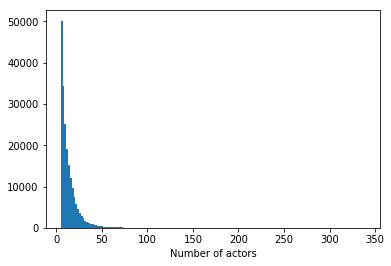

In [68]:
plt.hist(lengths__, bins=np.arange(min(lengths__), max(lengths__)+1,2))
plt.xlabel('Number of actors')
plt.ylabel('')
plt.plot()

In [69]:
len(movie_actor_lst)

468230

In [70]:
from itertools import combinations
from collections import namedtuple

In [73]:
movie_movie_map = defaultdict(int)
Mm = namedtuple("Mm",['m1','m2'])
i = 0
t = time.clock()

for row in fv:
    i +=1
    if(i%1000 ==0):
        t2 = time.clock()
        print(i,t2 - t)
        t= t2
    ml = [movie_id_map[x] for x in row[1]]
    ml = [x for x in ml if len(movie_actor_lst[x])>=5]
    comb = [Mm(sorted(x)[0],sorted(x)[1]) for x in list(combinations(ml,2))]
    for mm in comb:
        #print(mm)
        movie_movie_map[mm]+=1
#pickle.dump(movie_movie_map,open('mmm.pkl','wb'))    

1000 3.2589510000000104
2000 2.667835999999994
3000 1.6165249999999958
4000 3.088391999999999
5000 1.1800300000000021
6000 3.1285550000000057
7000 2.0676869999999923
8000 3.7942469999999986
9000 1.4629570000000172
10000 1.2447329999999965
11000 3.798449000000005
12000 2.2003469999999936
13000 3.1536839999999984
14000 4.086302999999987
15000 1.1237040000000036
16000 1.2784530000000132
17000 1.332570000000004
18000 1.666669999999982
19000 1.5619120000000066
20000 4.238232000000011
21000 1.8008529999999894
22000 1.396456999999998
23000 1.528886
24000 1.7216290000000072
25000 1.0417400000000043
26000 4.63306399999999
27000 5.485020999999989
28000 2.3255790000000047
29000 1.7120350000000144
30000 1.9601439999999855
31000 1.742176999999998
32000 8.829227000000003
33000 1.3709230000000048
34000 1.7623739999999941
35000 2.8795340000000067
36000 1.2920259999999928
37000 1.3652840000000026
38000 1.7499459999999942
39000 1.3026710000000037
40000 1.8085920000000044
41000 23.653737000000007
42000 1

In [74]:
print(len(movie_movie_map))

66469062


In [81]:
print(list(movie_actor_count.values())[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [100]:
movie_movie_weights_map = {}
movie_edge_l = []
with open('movie_edge_list.txt','w+')as  f:
    i = 0
    for k,v in movie_movie_map.items():
        i+=1
        if(i%100000 == 0):
            print(i)
        
        m1 = k.m1
        m2 = k.m2
        #print("%d\t%d\t%f\n"%(m1,m2,v*1.0/(len(movie_actor_lst_ge5[m1])+len(movie_actor_lst_ge5[m2])-v)))
        f.write("%d\t%d\t%f\n"%(m1,m2,v*1.0/(movie_actor_count[m1]+movie_actor_count[m2]-v)))
        

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000
1

In [101]:
with open('movie_edge_list.txt','w+')as  f:
    for x in list(movie_movie_map.keys())[:5]:
    print(x.m1)

IndentationError: expected an indented block (<ipython-input-101-b0ec22ec6f57>, line 3)